In [1]:
import torch
from models.gpt2_masks import CircuitDiscoveryGPT2, PruningConfig
from transformers import GPT2LMHeadModel, GPT2Tokenizer
# --- Configuration ---
MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define a pruning config for a perfect 1-to-1 test
# Gates are initialized to 1.0, and all sparsity penalties are off.
pruning_config_for_test = PruningConfig(
    init_value=1.0,
    lambda_attention=0.5,
    lambda_mlp=0.5,
    lambda_component=0.5,
    lambda_block=0.5,
)

# --- Model Initialization ---
print("--- Initializing Models ---")

# Use the NEW custom constructor for the prunable model
model = CircuitDiscoveryGPT2.from_pretrained_with_pruning(
    MODEL_NAME,
    pruning_config=pruning_config_for_test
).to(DEVICE).eval()

# Load the standard base model for comparison
base_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()
# --- Tokenizer Initialization ---
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print("--- Tokenizer Initialized ---")

--- Initializing Models ---
--- Tokenizer Initialized ---


In [6]:
# Import necessary libraries
from tqdm import tqdm
from typing import List, Dict
def test_ioi_circuit(model: CircuitDiscoveryGPT2, tokenizer: GPT2Tokenizer, test_data: List[Dict], device: str):
    """
    Tests the pruned model's ability to perform the IOI task on unseen examples.

    Args:
        model: The trained and masked model.
        tokenizer: The tokenizer.
        test_data: A list of dictionaries, each with 'prompt' and 'completion'.
        device: The device to run inference on.
    """
    print("\n" + "="*50)
    print("      PERFORMING INFERENCE ON THE PRUNED CIRCUIT")
    print("="*50 + "\n")
    
    model.eval() # Set the model to evaluation mode
    model.to(device)

    correct_predictions = 0
    total_predictions = len(test_data)

    with torch.no_grad(): # Disable gradient calculations for inference
        for i, item in enumerate(tqdm(test_data, desc="Testing Circuit")):
            prompt = item['prompt']
            expected_completion = item['completion']

            inputs = tokenizer(prompt, return_tensors='pt').to(device)
            
            # Generate completion. max_new_tokens is short since we only expect a name.
            output_sequences = model.generate(
                input_ids=inputs['input_ids'],
                max_new_tokens=6,
                pad_token_id=tokenizer.eos_token_id, # Suppress padding warning
                early_stopping=True
            )

            # Decode only the newly generated tokens
            generated_ids = output_sequences[0][inputs['input_ids'].shape[-1]:]
            generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

            # Check for correctness
            is_correct = generated_text.startswith(expected_completion)
            if is_correct:
                correct_predictions += 1
            
            # Print a few examples to see the output
            if i < 5 or not is_correct: # Print first 5 and any incorrect ones
                print(f"\nPrompt:      '{prompt}'")
                print(f"Expected:    '{expected_completion}'")
                print(f"Generated:   '{generated_text}'")
                print(f"Result:      {'✅ CORRECT' if is_correct else '❌ INCORRECT'}")

    accuracy = (correct_predictions / total_predictions) * 100
    print("\n" + "="*50)
    print(f"Circuit Performance Summary:")
    print(f"Correct Predictions: {correct_predictions} / {total_predictions}")
    print(f"Accuracy on IOI task: {accuracy:.2f}%")
    print("="*50)

Device: cuda
Total Model Parameters: 124.48M
Trainable Gate Parameters: 37044 (0.0298% of total)
Starting training...


Epoch 1/5: 100%|██████████| 125/125 [00:07<00:00, 16.67it/s]


Epoch 1 Summary: Avg Data Loss: 0.5483, Avg Sparsity Loss: 20.5833


Epoch 2/5: 100%|██████████| 125/125 [00:06<00:00, 18.22it/s]


Epoch 2 Summary: Avg Data Loss: 0.0341, Avg Sparsity Loss: 6.7755


Epoch 3/5: 100%|██████████| 125/125 [00:06<00:00, 18.25it/s]


Epoch 3 Summary: Avg Data Loss: 0.0264, Avg Sparsity Loss: 1.5262


Epoch 4/5: 100%|██████████| 125/125 [00:06<00:00, 18.10it/s]


Epoch 4 Summary: Avg Data Loss: 0.0205, Avg Sparsity Loss: 0.7655


Epoch 5/5: 100%|██████████| 125/125 [00:06<00:00, 18.08it/s]
/mounts/u-amo-d1/grad/mha361/work/circuits/trainers/gpt2.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(layer_indices), y=data_to_plot, ax=ax, palette=palette)
/mounts/u-amo-d1/grad/mha361/work/circuits/trainers/gpt2.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(layer_indices), y=data_to_plot, ax=ax, palette=palette)
/mounts/u-amo-d1/grad/mha361/work/circuits/trainers/gpt2.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(layer_indices), y=data_

Epoch 5 Summary: Avg Data Loss: 0.0187, Avg Sparsity Loss: 0.5329

Applying final circuit mask...
  Block 0 Attention Heads: 12/12 active
  Block 1 Attention Heads: 7/12 active
  Block 2 Attention Heads: 6/12 active
  Block 3 Attention Heads: 0/12 active
  Block 4 Attention Heads: 5/12 active
  Block 5 Attention Heads: 0/12 active
  Block 6 Attention Heads: 4/12 active
  Block 7 Attention Heads: 8/12 active
  Block 8 Attention Heads: 5/12 active
  Block 9 Attention Heads: 12/12 active
  Block 10 Attention Heads: 12/12 active
  Block 11 Attention Heads: 12/12 active


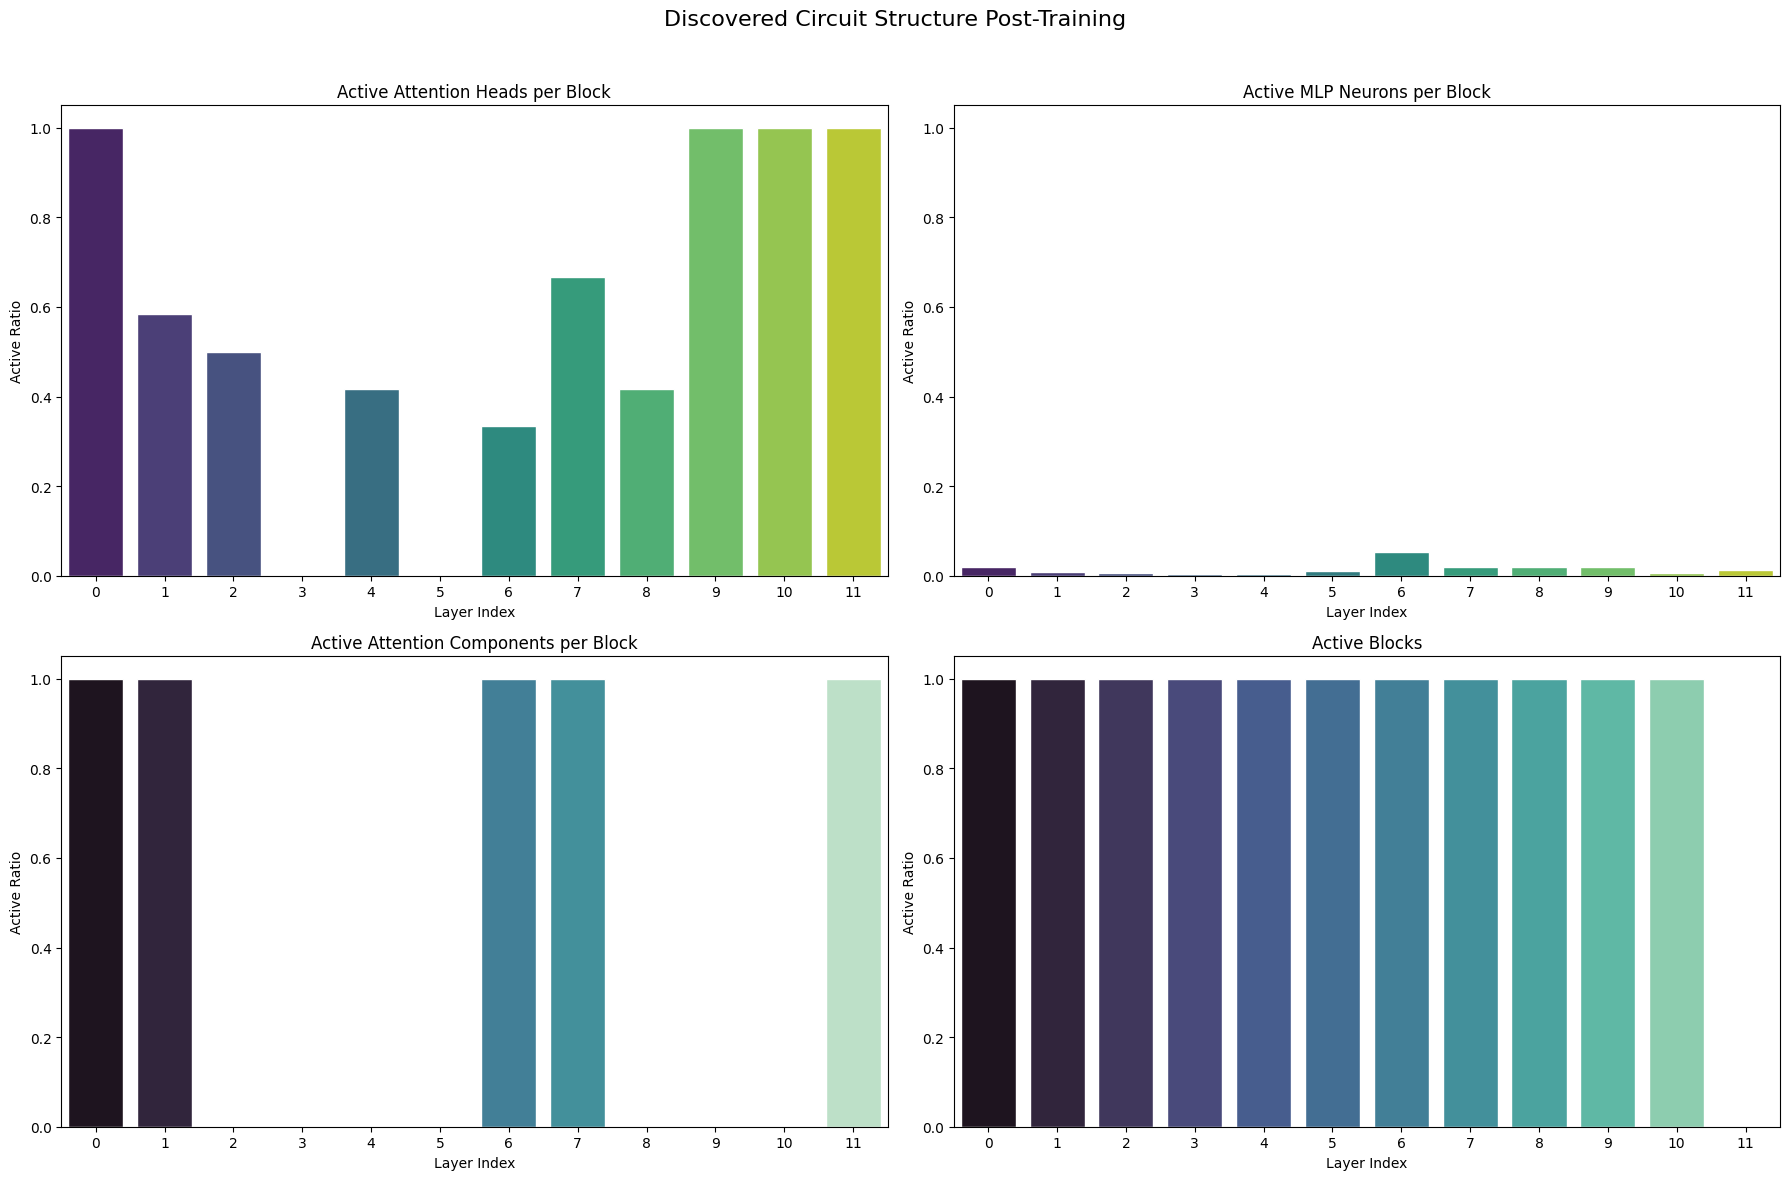

In [3]:
from dataset.ioi import IOIDataset, generate_ioi_sample
from torch.utils.data import DataLoader
from trainers.gpt2 import CircuitTrainer
from torch.optim import AdamW
if __name__ == '__main__':
    # --- Configuration ---
    MODEL_NAME = 'gpt2'
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-2 # Higher learning rate for gates is often effective
    BATCH_SIZE = 16
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # --- Setup Model and Tokenizer ---
    pruning_config = PruningConfig()
    model = CircuitDiscoveryGPT2.from_pretrained_with_pruning(MODEL_NAME, pruning_config)
    tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # --- Freeze Backbone, Isolate Gate Parameters ---
    gate_params = []
    total_params = 0
    for name, param in model.named_parameters():
        total_params += param.numel()
        if 'gate' in name:
            gate_params.append(param)
            param.requires_grad = True # Ensure gates are trainable
        else:
            param.requires_grad = False # Freeze all other parameters

    trainable_params = sum(p.numel() for p in gate_params)
    print(f"Device: {DEVICE}")
    print(f"Total Model Parameters: {total_params / 1e6:.2f}M")
    print(f"Trainable Gate Parameters: {trainable_params} ({(trainable_params / total_params) * 100:.4f}% of total)")

    # --- Setup Optimizer ---
    optimizer = AdamW(gate_params, lr=LEARNING_RATE)

    # --- Prepare Dataset ---
    names = ["Mary", "John", "Alice", "Bob", "Patricia", "James", "Linda", "Robert"]
    locations = ["store", "park", "cafe", "office", "school", "hospital"]
    objects = ["drink", "book", "gift", "letter", "key", "report"]
    
    # Generate a larger dataset for more stable training
    ioi_data = [generate_ioi_sample(names, locations, objects) for _ in range(2000)]
    ioi_dataset = IOIDataset(ioi_data, tokenizer)
    train_dataloader = DataLoader(ioi_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # --- Train the Circuit ---
    trainer = CircuitTrainer(model, tokenizer, device=DEVICE)
    trainer.train(train_dataloader, optimizer, num_epochs=NUM_EPOCHS)

    # --- Analyze the Result ---
    model.apply_circuit_mask(verbose=True)
    trainer.visualize_circuit_stats()


Device: cuda
Total Model Parameters: 124.48M
Trainable Gate Parameters: 37044 (0.0298% of total)
Starting training...


Epoch 1/5: 100%|██████████| 125/125 [00:06<00:00, 18.22it/s]


Epoch 1 Summary: Avg Data Loss: 0.5290, Avg Sparsity Loss: 20.6689


Epoch 2/5: 100%|██████████| 125/125 [00:06<00:00, 18.18it/s]


Epoch 2 Summary: Avg Data Loss: 0.0275, Avg Sparsity Loss: 6.8800


Epoch 3/5: 100%|██████████| 125/125 [00:06<00:00, 18.16it/s]


Epoch 3 Summary: Avg Data Loss: 0.0239, Avg Sparsity Loss: 1.5303


Epoch 4/5: 100%|██████████| 125/125 [00:06<00:00, 18.10it/s]


Epoch 4 Summary: Avg Data Loss: 0.0208, Avg Sparsity Loss: 0.8012


Epoch 5/5: 100%|██████████| 125/125 [00:07<00:00, 17.71it/s]
/mounts/u-amo-d1/grad/mha361/work/circuits/trainers/gpt2.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(layer_indices), y=data_to_plot, ax=ax, palette=palette)
/mounts/u-amo-d1/grad/mha361/work/circuits/trainers/gpt2.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(layer_indices), y=data_to_plot, ax=ax, palette=palette)
/mounts/u-amo-d1/grad/mha361/work/circuits/trainers/gpt2.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(layer_indices), y=data_

Epoch 5 Summary: Avg Data Loss: 0.0177, Avg Sparsity Loss: 0.5370

Applying final circuit mask...
  Block 0 Attention Heads: 12/12 active
  Block 1 Attention Heads: 8/12 active
  Block 2 Attention Heads: 7/12 active
  Block 3 Attention Heads: 0/12 active
  Block 4 Attention Heads: 7/12 active
  Block 5 Attention Heads: 1/12 active
  Block 6 Attention Heads: 6/12 active
  Block 7 Attention Heads: 10/12 active
  Block 8 Attention Heads: 6/12 active
  Block 9 Attention Heads: 12/12 active
  Block 10 Attention Heads: 12/12 active
  Block 11 Attention Heads: 12/12 active


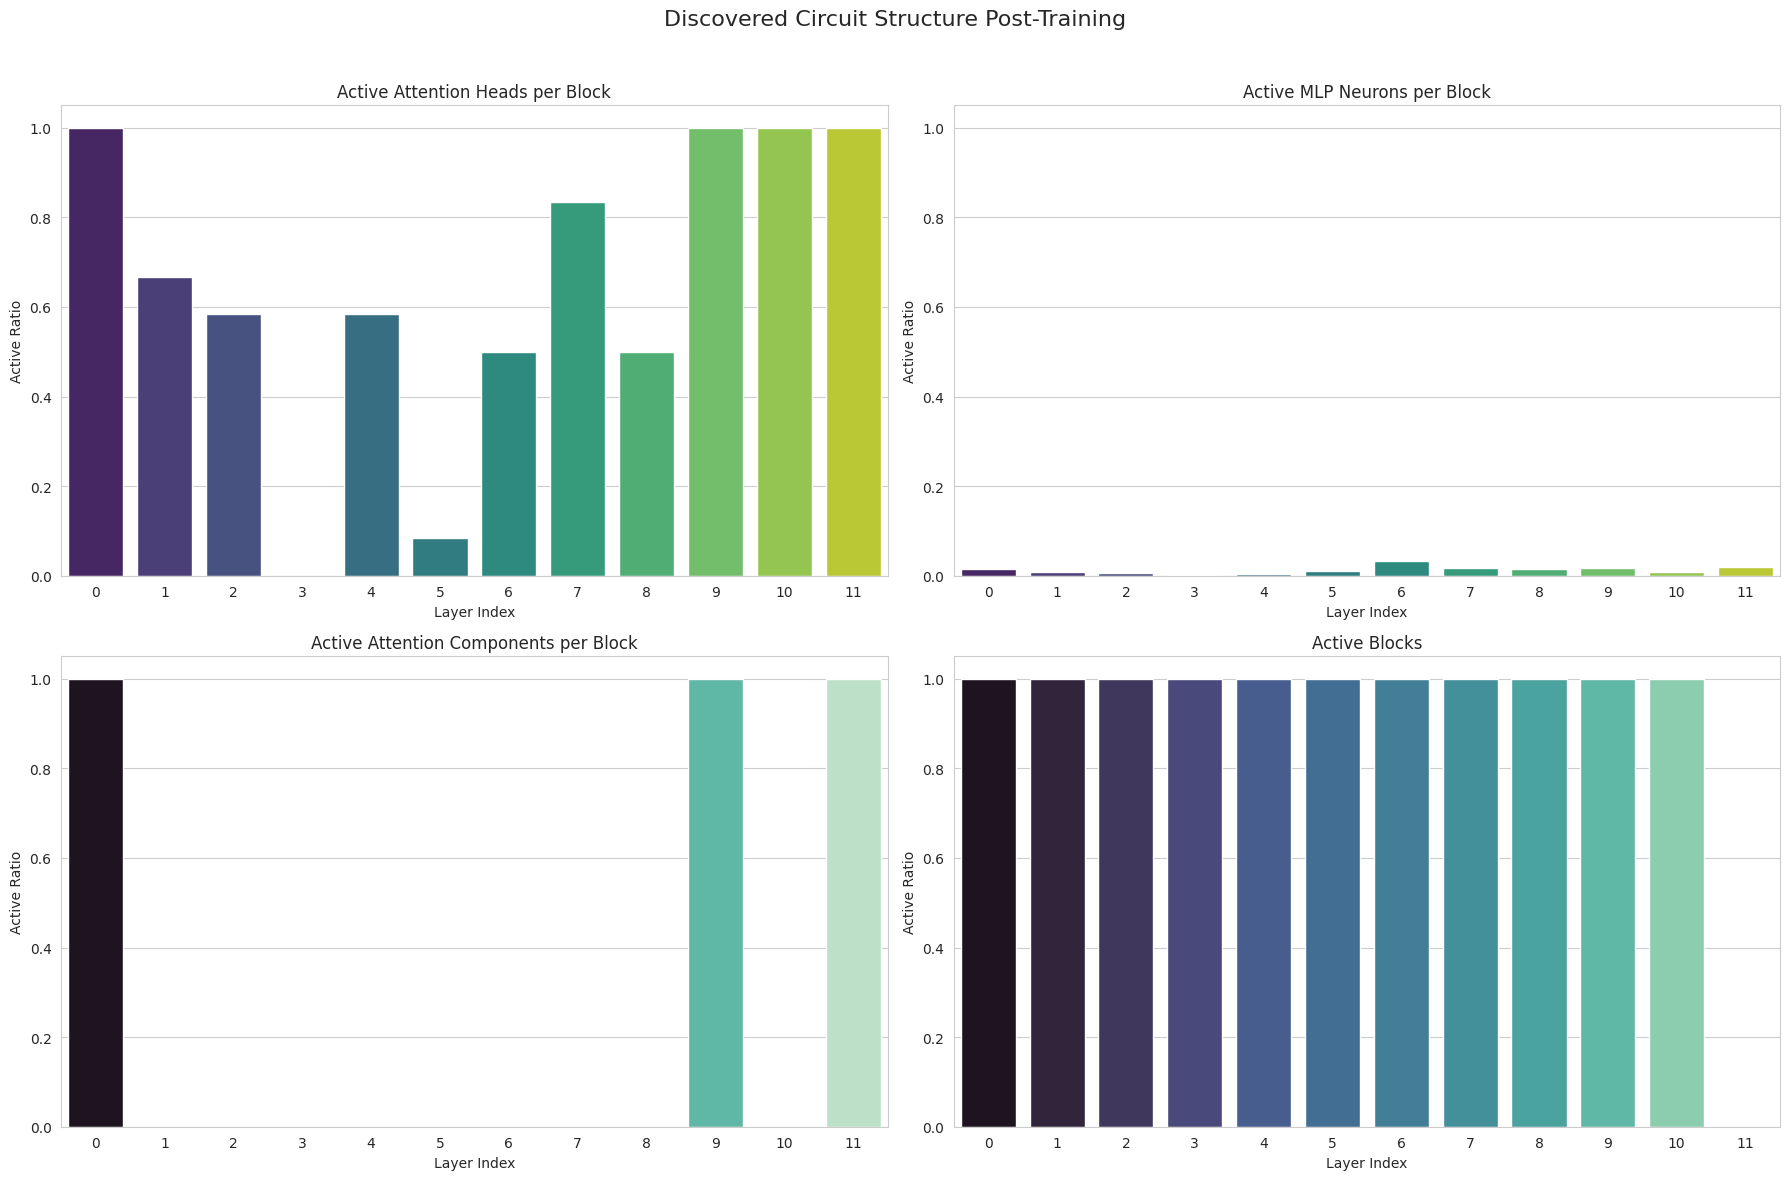


Generating a new set of unseen samples for testing...

      PERFORMING INFERENCE ON THE PRUNED CIRCUIT



Testing Circuit:   0%|          | 0/50 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for 


Prompt:      'When John and Robert went to the hospital, Robert gave a gift to'
Expected:    'John'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Mary and Patricia went to the office, Patricia gave a drink to'
Expected:    'Mary'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Bob and Linda went to the store, Linda gave a letter to'
Expected:    'Bob'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Alice and Bob went to the hospital, Bob gave a letter to'
Expected:    'Alice'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Bob and Alice went to the school, Alice gave a key to'
Expected:    'Bob'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Patricia and James went to the store, James gave a book to'
Expected:    'Patricia'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Mary and Patricia went to the park, Patricia gave a drink to'
Expected:    'Mary'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:     

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing Circuit:  32%|███▏      | 16/50 [00:00<00:00, 74.85it/s]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Prompt:      'When Mary and Linda went to the cafe, Linda gave a gift to'
Expected:    'Mary'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Mary and Alice went to the cafe, Alice gave a gift to'
Expected:    'Mary'
Generated:   ''
Result:      ❌ INCORRECT


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing Circuit:  48%|████▊     | 24/50 [


Prompt:      'When Bob and Robert went to the cafe, Robert gave a report to'
Expected:    'Bob'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Linda and Alice went to the school, Alice gave a gift to'
Expected:    'Linda'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Alice and Mary went to the hospital, Mary gave a book to'
Expected:    'Alice'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Mary and Bob went to the hospital, Bob gave a key to'
Expected:    'Mary'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Robert and Mary went to the store, Mary gave a letter to'
Expected:    'Robert'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Mary and James went to the hospital, James gave a key to'
Expected:    'Mary'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Patricia and James went to the school, James gave a gift to'
Expected:    'Patricia'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When L

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing Circuit:  64%|██████▍   | 32/50 [00:00<00:00, 77.45it/s]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Prompt:      'When Mary and Robert went to the store, Robert gave a book to'
Expected:    'Mary'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Robert and John went to the hospital, John gave a key to'
Expected:    'Robert'
Generated:   ''
Result:      ❌ INCORRECT


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing Circuit:  80%|████████  | 40/50 [


Prompt:      'When Patricia and Bob went to the office, Bob gave a letter to'
Expected:    'Patricia'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Bob and Patricia went to the office, Patricia gave a report to'
Expected:    'Bob'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Linda and Bob went to the park, Bob gave a book to'
Expected:    'Linda'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Linda and Alice went to the school, Alice gave a key to'
Expected:    'Linda'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Alice and Bob went to the office, Bob gave a book to'
Expected:    'Alice'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When James and Alice went to the cafe, Alice gave a key to'
Expected:    'James'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Patricia and Linda went to the school, Linda gave a report to'
Expected:    'Patricia'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'Whe

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing Circuit:  96%|█████████▌| 48/50 [00:00<00:00, 77.99it/s]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Prompt:      'When Linda and James went to the hospital, James gave a drink to'
Expected:    'Linda'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When Alice and James went to the cafe, James gave a book to'
Expected:    'Alice'
Generated:   ''
Result:      ❌ INCORRECT


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing Circuit: 100%|██████████| 50/50 [00:00<00:00, 77.29it/s]


Prompt:      'When John and Bob went to the store, Bob gave a gift to'
Expected:    'John'
Generated:   ''
Result:      ❌ INCORRECT

Prompt:      'When John and James went to the office, James gave a gift to'
Expected:    'John'
Generated:   ''
Result:      ❌ INCORRECT

Circuit Performance Summary:
Correct Predictions: 0 / 50
Accuracy on IOI task: 0.00%


: 

In [ ]:
# ==============================================================================
# 4. MAIN EXECUTION (Updated)
# ==============================================================================

if __name__ == '__main__':
    # --- Configuration ---
    MODEL_NAME = 'gpt2'
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-2 
    BATCH_SIZE = 16
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # --- Setup Model and Tokenizer ---
    pruning_config = PruningConfig()
    model = CircuitDiscoveryGPT2.from_pretrained_with_pruning(MODEL_NAME, pruning_config)
    tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token # Set pad token for batching
    model.to(DEVICE)

    # --- Freeze Backbone, Isolate Gate Parameters ---
    gate_params = []
    total_params = 0
    for name, param in model.named_parameters():
        total_params += param.numel()
        if 'gate' in name:
            gate_params.append(param)
            param.requires_grad = True 
        else:
            param.requires_grad = False 

    trainable_params = sum(p.numel() for p in gate_params)
    print(f"Device: {DEVICE}")
    print(f"Total Model Parameters: {total_params / 1e6:.2f}M")
    print(f"Trainable Gate Parameters: {trainable_params} ({(trainable_params / total_params) * 100:.4f}% of total)")

    # --- Setup Optimizer ---
    optimizer = AdamW(gate_params, lr=LEARNING_RATE)

    # --- Prepare Dataset ---
    names = ["Mary", "John", "Alice", "Bob", "Patricia", "James", "Linda", "Robert"]
    locations = ["store", "park", "cafe", "office", "school", "hospital"]
    objects = ["drink", "book", "gift", "letter", "key", "report"]
    
    ioi_data = [generate_ioi_sample(names, locations, objects) for _ in range(2000)]
    ioi_dataset = IOIDataset(ioi_data, tokenizer)
    train_dataloader = DataLoader(ioi_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # --- Train the Circuit ---
    trainer = CircuitTrainer(model, tokenizer, device=DEVICE)
    trainer.train(train_dataloader, optimizer, num_epochs=NUM_EPOCHS)

    # --- Analyze the Result ---
    model.apply_circuit_mask(verbose=True)
    trainer.visualize_circuit_stats()
    
    # =======================================================================
    # NEW: Test the pruned circuit on unseen data
    # =======================================================================
    
    # Generate a fresh, unseen test set
    print("\nGenerating a new set of unseen samples for testing...")
    ioi_test_data = [generate_ioi_sample(names, locations, objects) for _ in range(50)]

    # Run the inference test
    test_ioi_circuit(model, tokenizer, ioi_test_data, DEVICE)

In [1]:
import torch
torch.nn.Sigmoid(-100)

TypeError: Sigmoid.__init__() takes 1 positional argument but 2 were given

In [2]:
import random

# Define components for sentence generation
names = ["Mary", "John", "Alice", "Bob", "Patricia", "James", "Linda", "Robert"]
locations = ["store", "park", "cafe", "office", "school", "hospital"]
objects = ["drink", "book", "gift", "letter", "key", "report"]

def generate_ioi_sample(names_list, locations_list, objects_list):
    # Ensure at least two distinct names
    if len(names_list) < 2:
        raise ValueError("Need at least two names for IOI.")
    s_name, io_name = random.sample(names_list, 2) # Subject and Indirect Object

    # Randomly choose who gives the object
    giver = s_name
    receiver = io_name
    # Or, to make it more robust, sometimes flip them
    # if random.random() < 0.5:
    #     giver, receiver = receiver, giver

    loc = random.choice(locations_list)
    obj = random.choice(objects_list)

    # Template: "When [IO_Name] and [S_Name] went to the [Location], [S_Name] gave a [Object] to "
    # The model should predict [IO_Name]
    # More robust template from the paper:
    # "[S_Name] and [IO_Name] went to the [Location]. Then [S_Name] gave a [Object] to" -> [IO_Name]
    # Let's use a common one:
    # sentence_prompt = f"{s_name} and {io_name} went to the {loc}. Then {s_name} gave the {obj} to"
    # For your example: "When Mary and John went to the store, John gave a drink to " -> Mary
    # Here, John is S, Mary is IO.
    # Let's call them Name1 and Name2.
    name1, name2 = random.sample(names_list, 2)
    location = random.choice(locations_list)
    obj_item = random.choice(objects_list)

    # Scenario 1: Name2 is the IO
    # "When Name1 and Name2 went to the location, Name1 gave an object to" -> Name2
    # Scenario 2: Name1 is the IO
    # "When Name1 and Name2 went to the location, Name2 gave an object to" -> Name1

    # For your specific example: "When Mary and John went to the store, John gave a drink to "
    # Here, Mary is the IO (the one *not* giving). John is S (the giver).
    # Let's use distinct terms: giver_name, receiver_name
    giver_name, receiver_name = random.sample(names_list, 2)

    prompt = f"When {receiver_name} and {giver_name} went to the {location}, {giver_name} gave a {obj_item} to"
    correct_completion = receiver_name # The model should predict the receiver_name

    # Alternative template (simpler, often used)
    # prompt = f"{giver_name} and {receiver_name} went to the {location}. {giver_name} gave the {obj_item} to"
    # correct_completion = receiver_name

    return {
        "prompt": prompt,
        "target_S": giver_name,  # Subject / Giver
        "target_IO": receiver_name, # Indirect Object / Receiver
        "full_sentence_for_completion": f"{prompt} {receiver_name}."
    }

# Generate a few samples
ioi_dataset = [generate_ioi_sample(names, locations, objects) for _ in range(100)] # Create 100 samples

# Example:
sample = ioi_dataset[0]
print(f"Prompt: '{sample['prompt']}'")
print(f"Expected IO: '{sample['target_IO']}'")
print(f"Giver (S): '{sample['target_S']}'")

Prompt: 'When John and Robert went to the school, Robert gave a gift to'
Expected IO: 'John'
Giver (S): 'Robert'


In [4]:
from datasets import load_dataset

ds = load_dataset("fahamu/ioi")

In [5]:
ds['train'][0]

{'ioi_sentences': 'Friends Juana and Kristi found a mango at the bar. Kristi gave it to Juana'}

In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
# model = base_model
model.to(device)  # Ensure the model is on the correct device
base_model.to(device)  # Ensure the base model is also on the correct device
def get_ioi_predictions(model, tokenizer, ioi_sample, device):
    prompt_text = ioi_sample['prompt']
    # Tokenize the prompt. Ensure it ends with a space if the names are separate words.
    # For names like "Mary", they are often single tokens.
    # If the prompt is "John gave a drink to", the next token should be the first token of "Mary".
    # Many names are single tokens for GPT-2's tokenizer.
    # We might need to add a space at the end of the prompt to ensure the name is predicted as a whole word.
    # Or, handle multi-token names if necessary.
    if not prompt_text.endswith(" "):
        prompt_text += " "

    inputs = tokenizer(prompt_text, return_tensors='pt', padding=True).to(device)
    input_ids = inputs.input_ids

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs["logits"]

    # We care about the logits for the *next* token after the prompt
    next_token_logits = logits[0, -1, :] # Batch size 1, last token's logits

    # Get the token IDs for the target IO and S names
    # Add a leading space to tokenizer for names to match how they often appear after a space.
    target_io_token_id = tokenizer.encode(" " + ioi_sample['target_IO'], add_special_tokens=False)
    target_s_token_id = tokenizer.encode(" " + ioi_sample['target_S'], add_special_tokens=False)

    # Handle if names are multi-token (for simplicity, assume single token for now)
    # This is a simplification; robust IOI checks if the *first* token of the name is predicted.
    if len(target_io_token_id) == 0 or len(target_s_token_id) == 0:
        return {
            "prompt": prompt_text,
            "predicted_token_id": None,
            "predicted_token_str": "[ERROR: Empty token for name]",
            "logit_IO": -float('inf'),
            "logit_S": -float('inf'),
            "is_correct": False
        }

    target_io_token_id = target_io_token_id[0]
    target_s_token_id = target_s_token_id[0]


    logit_for_io = next_token_logits[target_io_token_id].item()
    logit_for_s = next_token_logits[target_s_token_id].item()

    # Get the predicted token
    predicted_token_id = torch.argmax(next_token_logits).item()
    predicted_token_str = tokenizer.decode(predicted_token_id)

    is_correct = (predicted_token_id == target_io_token_id)

    return {
        "prompt": prompt_text,
        "predicted_token_id": predicted_token_id,
        "predicted_token_str": predicted_token_str.strip(), # strip potential leading space
        "logit_IO": logit_for_io,
        "logit_S": logit_for_s,
        "is_correct": is_correct,
        "target_IO_token_id": target_io_token_id,
        "target_S_token_id": target_s_token_id
    }

# Example usage:
if len(ioi_dataset) > 0:
    print("Base_Model Sample Evaluation:")
    sample_result = get_ioi_predictions(base_model, tokenizer, ioi_dataset[0], device)
    print("\nIOI Sample Evaluation:")
    print(f"  Prompt: '{sample_result['prompt']}'")
    print(f"  Target IO: '{ioi_dataset[0]['target_IO']}' (Token ID: {sample_result['target_IO_token_id']})")
    print(f"  Target S (distractor): '{ioi_dataset[0]['target_S']}' (Token ID: {sample_result['target_S_token_id']})")
    print(f"  Predicted Token: '{sample_result['predicted_token_str']}' (ID: {sample_result['predicted_token_id']})")
    print(f"  Logit for Correct IO ({ioi_dataset[0]['target_IO']}): {sample_result['logit_IO']:.2f}")
    print(f"  Logit for S ({ioi_dataset[0]['target_S']}): {sample_result['logit_S']:.2f}")
    print(f"  Is correct (top prediction is IO)?: {sample_result['is_correct']}")
    
if len(ioi_dataset) > 0:
    print("Prunable Model Sample Evaluation:")
    sample_result = get_ioi_predictions(model, tokenizer, ioi_dataset[0], device)
    print("\nIOI Sample Evaluation:")
    print(f"  Prompt: '{sample_result['prompt']}'")
    print(f"  Target IO: '{ioi_dataset[0]['target_IO']}' (Token ID: {sample_result['target_IO_token_id']})")
    print(f"  Target S (distractor): '{ioi_dataset[0]['target_S']}' (Token ID: {sample_result['target_S_token_id']})")
    print(f"  Predicted Token: '{sample_result['predicted_token_str']}' (ID: {sample_result['predicted_token_id']})")
    print(f"  Logit for Correct IO ({ioi_dataset[0]['target_IO']}): {sample_result['logit_IO']:.2f}")
    print(f"  Logit for S ({ioi_dataset[0]['target_S']}): {sample_result['logit_S']:.2f}")
    print(f"  Is correct (top prediction is IO)?: {sample_result['is_correct']}")

Base_Model Sample Evaluation:

IOI Sample Evaluation:
  Prompt: 'When John and Robert went to the school, Robert gave a gift to '
  Target IO: 'John' (Token ID: 1757)
  Target S (distractor): 'Robert' (Token ID: 5199)
  Predicted Token: '' (ID: 1849)
  Logit for Correct IO (John): -70.30
  Logit for S (Robert): -70.08
  Is correct (top prediction is IO)?: False
Prunable Model Sample Evaluation:

IOI Sample Evaluation:
  Prompt: 'When John and Robert went to the school, Robert gave a gift to '
  Target IO: 'John' (Token ID: 1757)
  Target S (distractor): 'Robert' (Token ID: 5199)
  Predicted Token: '' (ID: 1849)
  Logit for Correct IO (John): -70.30
  Logit for S (Robert): -70.08
  Is correct (top prediction is IO)?: False


In [4]:
def evaluate_ioi_dataset(model, tokenizer, dataset, device):
    correct_predictions = 0
    total_predictions = len(dataset)
    logit_diffs = []
    all_results = []

    for sample in dataset:
        # Ensure names are in the tokenizer's vocabulary as single tokens (with leading space) for this simplified eval
        # A more robust check might be needed if names are multi-token or not perfectly tokenized
        io_token_ids = tokenizer.encode(" " + sample['target_IO'], add_special_tokens=False)
        s_token_ids = tokenizer.encode(" " + sample['target_S'], add_special_tokens=False)

        if not io_token_ids or not s_token_ids:
            print(f"Warning: Could not tokenize IO ('{sample['target_IO']}') or S ('{sample['target_S']}') properly. Skipping sample: {sample['prompt']}")
            total_predictions -=1 # Adjust total count
            continue


        result = get_ioi_predictions(model, tokenizer, sample, device)
        all_results.append(result)

        if result['is_correct']:
            correct_predictions += 1
        if result['logit_IO'] > -float('inf') and result['logit_S'] > -float('inf'): # Ensure valid logits
             logit_diffs.append(result['logit_IO'] - result['logit_S'])

    accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
    avg_logit_diff = sum(logit_diffs) / len(logit_diffs) if len(logit_diffs) > 0 else float('nan')

    return {
        "accuracy": accuracy,
        "average_logit_difference_IO_S": avg_logit_diff,
        "num_samples_evaluated": total_predictions,
        "individual_results": all_results
    }

# Run evaluation
ioi_eval_results = evaluate_ioi_dataset(model, tokenizer, ioi_dataset, device)
print("\n--- IOI Task Evaluation ---")
print(f"Accuracy: {ioi_eval_results['accuracy']:.2f}%")
print(f"Average Logit Difference (IO - S): {ioi_eval_results['average_logit_difference_IO_S']:.2f}")
print(f"Total samples evaluated: {ioi_eval_results['num_samples_evaluated']}")


--- IOI Task Evaluation ---
Accuracy: 0.00%
Average Logit Difference (IO - S): 0.33
Total samples evaluated: 100


In [5]:
def generate_greater_than_sample():
    start_year = random.randint(1000, 2025) # Full start year
    year_prefix = str(start_year)[:2] # First two digits (e.g., "17" from 1732)
    year_suffix_val = int(str(start_year)[2:]) # Last two digits as int (e.g., 32 from 1732)

    # Create a context sentence
    contexts = [
        "The treaty was signed from the year {start_year} to the year {year_prefix}",
        "It was effective from {start_year} until {year_prefix}",
        "The records span {start_year} through {year_prefix}",
        "The period lasted from the year {start_year} to the year {year_prefix}"
    ]
    prompt_template = random.choice(contexts)
    prompt = prompt_template.format(start_year=start_year, year_prefix=year_prefix)

    return {
        "prompt": prompt,
        "start_year": start_year,
        "year_prefix": year_prefix, # e.g. "17"
        "threshold_suffix": year_suffix_val # e.g. 32. The prediction must be > this.
    }

# Generate a dataset
greater_than_dataset = [generate_greater_than_sample() for _ in range(100)]

# Example:
sample_gt = greater_than_dataset[0]
print(f"Prompt: '{sample_gt['prompt']}'")
print(f"Start Year: {sample_gt['start_year']}")
print(f"Year Prefix (for prompt): '{sample_gt['year_prefix']}'")
print(f"Threshold Suffix (prediction must be > this): {sample_gt['threshold_suffix']}")

Prompt: 'It was effective from 1785 until 17'
Start Year: 1785
Year Prefix (for prompt): '17'
Threshold Suffix (prediction must be > this): 85


In [6]:
def get_greater_than_predictions(model, tokenizer, gt_sample, device, max_new_tokens=2):
    prompt_text = gt_sample['prompt']
    # Ensure the prompt ends with the prefix and potentially a space if needed
    # e.g., "... to the year 17"
    # The model should predict "33", "34", ... "99" for start_year 1732
    if not prompt_text.endswith(gt_sample['year_prefix']):
         # This should not happen if data gen is correct, but as a safeguard:
        print(f"Warning: Prompt '{prompt_text}' doesn't end with prefix '{gt_sample['year_prefix']}'")

    inputs = tokenizer(prompt_text, return_tensors='pt').to(device)

    # Generate the next two tokens
    # Using greedy decoding here. For more nuanced analysis, you might look at logits directly.
    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id, # Stop if EOS is generated
        num_return_sequences=1,
        do_sample=False # Greedy
    )

    # Extract only the generated tokens
    generated_ids = outputs[0, inputs.input_ids.shape[1]:]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)

    # Try to parse the generated text as two digits
    predicted_suffix_str = ""
    predicted_suffix_val = -1 # Default to invalid
    is_valid_format = False # Was it two digits?

    # We expect two digits. Let's check the raw generated tokens for digits.
    digit_tokens = []
    current_num_str = ""

    for token_id in generated_ids:
        token_str = tokenizer.decode(token_id)
        # Check if the token string itself is a digit or part of a multi-digit number token
        if token_str.strip().isdigit():
            current_num_str += token_str.strip()
            if len(current_num_str) >= 2:
                break
        else: # if a non-digit is generated early, stop.
            break

    if len(current_num_str) == 2 and current_num_str.isdigit():
        predicted_suffix_str = current_num_str
        predicted_suffix_val = int(current_num_str)
        is_valid_format = True

    is_correct_greater_than = False
    if is_valid_format:
        is_correct_greater_than = (predicted_suffix_val > gt_sample['threshold_suffix'] and predicted_suffix_val <=99)

    return {
        "prompt": prompt_text,
        "start_year": gt_sample['start_year'],
        "threshold_suffix": gt_sample['threshold_suffix'],
        "generated_text_full": generated_text,
        "predicted_suffix_str": predicted_suffix_str, # The two digits like "35"
        "predicted_suffix_val": predicted_suffix_val, # The integer value like 35
        "is_valid_two_digit_format": is_valid_format,
        "is_correct_greater_than": is_correct_greater_than
    }


# Example usage:
if len(greater_than_dataset) > 0:
    sample_gt_result = get_greater_than_predictions(model, tokenizer, greater_than_dataset[0], device)
    print("\nGreater-Than Sample Evaluation:")
    print(f"  Prompt: '{sample_gt_result['prompt']}'")
    print(f"  Start Year: {sample_gt_result['start_year']}")
    print(f"  Threshold Suffix: > {sample_gt_result['threshold_suffix']}")
    print(f"  Generated Text (raw): '{sample_gt_result['generated_text_full']}'")
    print(f"  Predicted Suffix (parsed): '{sample_gt_result['predicted_suffix_str']}' (Value: {sample_gt_result['predicted_suffix_val']})")
    print(f"  Is valid two-digit format?: {sample_gt_result['is_valid_two_digit_format']}")
    print(f"  Is correct (prediction > threshold)?: {sample_gt_result['is_correct_greater_than']}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Greater-Than Sample Evaluation:
  Prompt: 'It was effective from 1785 until 17'
  Start Year: 1785
  Threshold Suffix: > 85
  Generated Text (raw): '90,'
  Predicted Suffix (parsed): '90' (Value: 90)
  Is valid two-digit format?: True
  Is correct (prediction > threshold)?: True


In [ ]:
def evaluate_greater_than_dataset(model, tokenizer, dataset, device):
    num_valid_format = 0
    num_correct_greater_than = 0
    total_samples = len(dataset)
    all_results = []

    for sample in dataset:
        result = get_greater_than_predictions(model, tokenizer, sample, device)
        all_results.append(result)

        if result['is_valid_two_digit_format']:
            num_valid_format += 1
            if result['is_correct_greater_than']:
                num_correct_greater_than += 1

    format_adherence_rate = (num_valid_format / total_samples) * 100 if total_samples > 0 else 0
    # Strict accuracy: must be valid format AND correct comparison
    strict_accuracy = (num_correct_greater_than / total_samples) * 100 if total_samples > 0 else 0
    # Conditional accuracy: if it gave two digits, was the comparison correct?
    valid_range_accuracy = (num_correct_greater_than / num_valid_format) * 100 if num_valid_format > 0 else 0


    return {
        "format_adherence_rate": format_adherence_rate,
        "strict_accuracy": strict_accuracy,
        "valid_range_accuracy_given_correct_format": valid_range_accuracy,
        "num_samples_evaluated": total_samples,
        "num_valid_format_generated": num_valid_format,
        "num_correct_logic": num_correct_greater_than,
        "individual_results": all_results
    }

# Run evaluation
gt_eval_results = evaluate_greater_than_dataset(model, tokenizer, greater_than_dataset, device)
print("\n--- Greater-Than Task Evaluation ---")
print(f"Format Adherence Rate (generated two digits): {gt_eval_results['format_adherence_rate']:.2f}%")
print(f"Strict Accuracy (valid format AND correct logic): {gt_eval_results['strict_accuracy']:.2f}%")
print(f"Valid Range Accuracy (if two digits, was logic correct?): {gt_eval_results['valid_range_accuracy_given_correct_format']:.2f}%")
print(f"Total samples: {gt_eval_results['num_samples_evaluated']}")
print(f"Number of valid two-digit generations: {gt_eval_results['num_valid_format_generated']}")
print(f"Number of correct logic predictions: {gt_eval_results['num_correct_logic']}")


--- Greater-Than Task Evaluation ---
Format Adherence Rate (generated two digits): 99.00%
Strict Accuracy (valid format AND correct logic): 90.00%
Valid Range Accuracy (if two digits, was logic correct?): 90.91%
Total samples: 100
Number of valid two-digit generations: 99
Number of correct logic predictions: 90


In [12]:
from datasets import load_from_disk

# Path where the dataset from the paper's script was saved
dataset_path = "/u/amo-d1/grad/mha361/work/circuits/data/edge_pruning/datasets/ioi" 
data = load_from_disk(dataset_path)


In [13]:
data

DatasetDict({
    train: Dataset({
        features: ['a', 'b', 'object', 'place', 'template', 'order', 'ioi_sentences', 'corr_a', 'corr_b', 'corr_object', 'corr_place', 'corr_template', 'corr_order', 'corr_ioi_sentences'],
        num_rows: 200
    })
    train_400: Dataset({
        features: ['a', 'b', 'object', 'place', 'template', 'order', 'ioi_sentences', 'corr_a', 'corr_b', 'corr_object', 'corr_place', 'corr_template', 'corr_order', 'corr_ioi_sentences'],
        num_rows: 400
    })
    train_100k: Dataset({
        features: ['a', 'b', 'object', 'place', 'template', 'order', 'ioi_sentences', 'corr_a', 'corr_b', 'corr_object', 'corr_place', 'corr_template', 'corr_order', 'corr_ioi_sentences'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['a', 'b', 'object', 'place', 'template', 'order', 'ioi_sentences', 'corr_a', 'corr_b', 'corr_object', 'corr_place', 'corr_template', 'corr_order', 'corr_ioi_sentences'],
        num_rows: 200
    })
    test: Da

In [14]:
data['train'][1]

{'a': 'Angie',
 'b': 'Yvette',
 'object': 'banana',
 'place': 'mountain',
 'template': 'Then, {B} and {A} were working at the {PLACE}. {B} decided to give a {OBJECT} to {A}',
 'order': 'baba',
 'ioi_sentences': 'Then, Yvette and Angie were working at the mountain. Yvette decided to give a banana to Angie',
 'corr_a': 'Evan',
 'corr_b': 'Evelyn',
 'corr_object': 'banana',
 'corr_place': 'mountain',
 'corr_template': 'Then, {B} and {A} were working at the {PLACE}. {B} decided to give a {OBJECT} to {A}',
 'corr_order': 'baba',
 'corr_ioi_sentences': 'Then, Evelyn and Evan were working at the mountain. Angelique decided to give a banana to Nathanael'}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import Gemma2ForCausalLM, GemmaTokenizer
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Optional
from tqdm import tqdm
import random
# from models.gpt2_circuit import PrunableGPT2LMHeadModel as CircuitDiscoveryGPT2, GPT2LMHeadModel,PruningConfig
from dataset.gt_gpt2 import GTDataset, load_or_generate_gt_data, create_two_digit_token_mapping, run_evaluation

# from models.gemma_test import PruningConfig

import torch
import torch.nn as nn
from tqdm import tqdm
from models.l0 import HardConcreteGate

import torch
import torch.nn as nn
from tqdm import tqdm
from utils import disable_dropout, analyze_and_finalize_circuit
# ==============================================================================
# PRUNING CONFIGURATION
# ==============================================================================
from dataclasses import dataclass
prune_factor = 0.05
@dataclass
class PruningConfig:
    init_value: float = 1.0
    sparsity_warmup_steps: int = 1

    # --- Control Panel for Pruning Granularity ---
    
    # Attention Head Pruning (what we already have)
    prune_attention_heads: bool = True
    lambda_attention_heads: float = 0.01 * prune_factor  # The penalty for the attention head gates

    # --- NEW: Separate controls for each MLP layer ---
    prune_mlp_hidden: bool = True       # Prune the intermediate "fat" layer of the MLP
    lambda_mlp_hidden: float = 0.0005 * prune_factor     # The penalty for the hidden layer gates

    prune_mlp_output: bool = True      # Prune the final output of the entire MLP sub-block
    lambda_mlp_output: float = 0.0005 * prune_factor    # The penalty for the output gates
    
    prune_embedding: bool = False
    lambda_embedding: float = 0.1 * prune_factor# This is a crucial hyperparameter to tune
# ==============================================================================
# 5. MAIN EXECUTION (WITH FINAL CORRECTION)
# ==============================================================================
if __name__ == '__main__':
    # --- Configuration ---
    # (Same as before)
    MODEL_NAME = 'google/gemma-2b'
    NUM_EPOCHS = 10
    LEARNING_RATE = 5e-3
    BATCH_SIZE = 2
    MAX_SEQ_LEN = 128
    PROB_DIFF_BUDGET = 0.2
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    pruning_config = PruningConfig()
    

    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    full_model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B").to(DEVICE).eval()

    
    # # ----- Disable all built-in dropout layers in the circuit model ---
    # print("\n--- Disabling all built-in dropout layers in the circuit model ---")
    # disable_dropout(circuit_model)
    # # -----------------------------------------------------------------
    
    
    # # --- Freeze the base model and unfreeze only the gates ---
    # print("Freezing base model weights and unfreezing gate parameters...")
    # total_params = 0
    # trainable_params = 0
    # for name, param in circuit_model.named_parameters():
    #     total_params += param.numel()
    #     if 'gate' not in name:
    #         param.requires_grad = False
    #     else:
    #         print(f"  Unfreezing for training: {name}")
    #         param.requires_grad = True
    #         trainable_params += param.numel()
            
    # print(f"\nTotal parameters: {total_params}")
    # print(f"Trainable gate parameters: {trainable_params} ({trainable_params/total_params*100:.4f}%)")

    # --- Dataset Setup ---
    print("\nSetting up dataset...")
    # Load from disk with fallback to generation
    train_data = load_or_generate_gt_data(split="train")
    val_data = load_or_generate_gt_data(split="validation")
    test_data = load_or_generate_gt_data(split="test")

    # Create dataset objects
    train_dataset = GTDataset(train_data, tokenizer, max_length=MAX_SEQ_LEN)
    val_dataset = GTDataset(val_data, tokenizer, max_length=MAX_SEQ_LEN)
    test_dataset = GTDataset(test_data, tokenizer, max_length=MAX_SEQ_LEN)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Create token mapping
    two_digit_tokens = create_two_digit_token_mapping(tokenizer)


    # --- Baseline Evaluation ---
    baseline_results = run_evaluation(model_to_eval=full_model, model_name="Baseline Full Model", full_model_for_faithfulness=None, dataloader=test_dataloader, device=DEVICE, two_digit_tokens=two_digit_tokens, tokenizer=tokenizer)
    base_prob_diff = baseline_results.get("prob_diff", 0.0)
    
    # # --- Test Circuit model ---
    
    # print("\n--- Initial evaluation of the Circuit Discovery Model ---")
    # circuit_model.eval()
    # initial_results = run_evaluation(model_to_eval=circuit_model, model_name="Initial Circuit Model", full_model_for_faithfulness=full_model, dataloader=val_dataloader, device=DEVICE, two_digit_tokens=two_digit_tokens)
    # initial_prob_diff = initial_results.get("prob_diff", 0.0)

    # # --- Training ---
    # # The optimizer will now only see the parameters that require gradients (the gates)
    # gate_params = [p for p in circuit_model.parameters() if p.requires_grad]
    # optimizer = AdamW(gate_params, lr=LEARNING_RATE)
    
    # print(f"\n--- Starting training to find 'Greater-Than' circuit ---")
    # circuit_model.train()
    # total_steps = 0
    # for epoch in range(NUM_EPOCHS):
    #     for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
    #         optimizer.zero_grad()
    #         for key, val in batch.items():
    #             if isinstance(val, torch.Tensor): batch[key] = val.to(DEVICE)
            
    #         circuit_outputs = circuit_model(input_ids=batch['clean_input_ids'], corrupted_input_ids=batch['corrupted_input_ids'], attention_mask=batch['clean_attention_mask'])
    #         with torch.no_grad():
    #             target_outputs = full_model(input_ids=batch['clean_input_ids'], attention_mask=batch['clean_attention_mask'])

    #         last_token_circuit_logits = circuit_outputs.logits[torch.arange(circuit_outputs.logits.size(0)), batch['last_token_idx'], :]
    #         last_token_target_logits = target_outputs.logits[torch.arange(target_outputs.logits.size(0)), batch['last_token_idx'], :]

    #         kl_loss = F.kl_div(F.log_softmax(last_token_circuit_logits, dim=-1), F.log_softmax(last_token_target_logits, dim=-1), reduction='batchmean', log_target=True)
    #         sparsity_loss = circuit_model.get_sparsity_loss(step=total_steps)['total_sparsity']
            
    #         loss = kl_loss + sparsity_loss
    #         loss.backward()
    #         optimizer.step()
    #         total_steps += 1
        
    #     # --- Epoch Validation ---
    #     run_evaluation(model_to_eval=circuit_model, model_name=f"Circuit after Epoch {epoch+1}", full_model_for_faithfulness=full_model, dataloader=val_dataloader, device=DEVICE, two_digit_tokens=two_digit_tokens)
    #     circuit_model.train()

    # analyze_and_finalize_circuit(circuit_model)
    

    # final_results = run_evaluation(model_to_eval=circuit_model, model_name="Final Pruned Circuit (Optimal Thresholds)", full_model_for_faithfulness=full_model, dataloader=test_dataloader, device=DEVICE, two_digit_tokens=two_digit_tokens)

tokenizer_config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/930 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/24.2G [00:00<?, ?B/s]

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi


Setting up dataset...
Attempting to load dataset from: /u/amo-d1/grad/mha361/work/circuits/data/edge_pruning/datasets/gt
Successfully loaded train split with 150 samples
Attempting to load dataset from: /u/amo-d1/grad/mha361/work/circuits/data/edge_pruning/datasets/gt
Successfully loaded validation split with 150 samples
Attempting to load dataset from: /u/amo-d1/grad/mha361/work/circuits/data/edge_pruning/datasets/gt
Successfully loaded test split with 12240 samples
Creating two-digit token mapping...
Successfully mapped 97 two-digit numbers to tokens

  EVALUATING: Baseline Full Model (with Re-Normalization)


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 23.57 GiB of which 31.56 MiB is free. Including non-PyTorch memory, this process has 23.53 GiB memory in use. Of the allocated memory 23.17 GiB is allocated by PyTorch, and 63.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)